In [2]:
# # Install nightly package for some functionalities that aren't in alpha
# # !pip install tensorflow-gpu==2.0.0-beta1
# !pip install tensorflow-gpu
# # Install TF Hub for TF2
# # !pip install 'tensorflow-hub == 0.5'
# !pip install tensorflow-hub

In [23]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()
from PIL import Image, ImageOps
import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers




In [24]:
# # verify TensorFlow version

# print("Version: ", tf.__version__)
# print("Eager mode: ", tf.executing_eagerly())
# print("Hub version: ", hub.__version__)
# # print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")
# # tf.config.list_physical_devices('GPU')


In [25]:
# zip_file = tf.keras.utils.get_file(origin='https://storage.googleapis.com/plantdata/PlantVillage.zip', 
#                                    fname='PlantVillage.zip', extract=True)


In [26]:
# data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
# train_dir = os.path.join(data_dir, 'train')
# validation_dir = os.path.join(data_dir, 'validation')


In [27]:
data_dir = './data'
train_dir = './data/train'
validation_dir = './data/valid'

In [28]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [29]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))


total images for training : ./data/train : 70295files
total images for validation : ./data/valid : 17572files


In [30]:
# !!wget https://github.com/obeshor/Plant-Diseases-Detector/archive/master.zip
# !unzip master.zip;

In [31]:
import json

with open('categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [32]:
print('Number of classes:',len(classes))

Number of classes: 38


###Setup Image shape and  batch size

In [33]:


IMAGE_SHAPE = (224, 224)

BATCH_SIZE = 64 #@param {type:"integer"}

In [34]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)


Found 17572 images belonging to 38 classes.
Found 70295 images belonging to 38 classes.


In [35]:

model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])


In [36]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



In [37]:
from PIL import Image, ImageOps

EPOCHS=10 #@param {type:"integer"}

history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

In [38]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

NameError: name 'history' is not defined

In [ ]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

In [39]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

SOURCE: class: Cherry_(including_sour)___healthy, file: Cherry_(including_sour)___healthy\5145073c-b7b7-4127-b856-860a402ddd30___JR_HL 4191.JPG


error: OpenCV(4.5.2) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-sgoydvi3\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [0]:
Export as saved model and convert   to TFLite

import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

export_path

W0704 18:42:59.711274 139649001609088 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:253: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
W0704 18:42:59.713187 139649001609088 export_utils.py:182] Export includes no default signature!
W0704 18:43:00.372470 139649001609088 meta_graph.py:450] Issue encountered when serializing variables.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
W0704 18:43:07.073518 139649001609088 export_utils.py:182] Export includes no default signature!
W0704 18:43:07.691617 139649001609088 m

'/tmp/saved_models/1562265771'

In [0]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [0]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Raspberry___healthy, file: Raspberry___healthy/f40dd477-0530-4619-a99a-03a51f053dfe___Mary_HL 9167.JPG
PREDICTED: class: Raspberry___healthy, confidence: 0.820325


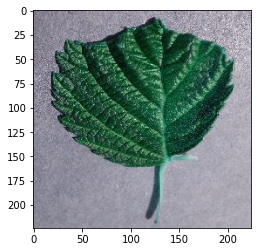

<Figure size 432x288 with 0 Axes>

SOURCE: class: Tomato___Late_blight, file: Tomato___Late_blight/ed6a8fb9-9fa8-4d3d-a727-676ec58d147a___RS_Late.B 7036.JPG
PREDICTED: class: Tomato___Late_blight, confidence: 0.911603


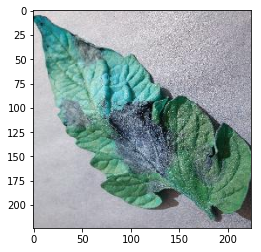

In [0]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()